<a href="https://colab.research.google.com/github/olesyamba/Risk_analysis/blob/main/VaR_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
!pip install yfinance
import yfinance as yf

In [ ]:
quotes = yf.download("AAPL", "2016-01-01", "2020-12-31")
returns = quotes['Adj Close'].pct_change().dropna()
returns.head()

[*********************100%***********************]  1 of 1 completed


Date
2016-01-05   -0.025059
2016-01-06   -0.019570
2016-01-07   -0.042205
2016-01-08    0.005288
2016-01-11    0.016192
Name: Adj Close, dtype: float64

In [ ]:
# Эмпирическая оценка VaR

level = 0.99
VaRs = returns.rolling(252, closed="left").apply(lambda x:-x.quantile(1 - level)).dropna()
display(VaRs)
#дроп нэ надо чтобы первые нулевые удалились, нампай и пандас, реализуя методы по отношению к массиву, не меняют их размерность, просто заполняют нэ
#парметрическая оценка вар: х это ретернс, а именно кусочек в 252 дня, это написано для норм распр, можно менять на любое

VaRs_param = returns.rolling(252, closed="left").apply(lambda x:- ss.norm.ppf(1 - level, *ss.norm.fit(x))).dropna()
display(VaRs_param)

Date
2017-01-04    0.036269
2017-01-05    0.036269
2017-01-06    0.036269
2017-01-09    0.029306
2017-01-10    0.029306
                ...   
2020-12-23    0.079567
2020-12-24    0.079567
2020-12-28    0.079567
2020-12-29    0.079567
2020-12-30    0.079567
Name: Adj Close, Length: 1005, dtype: float64

Date
2017-01-04    0.033552
2017-01-05    0.033250
2017-01-06    0.033028
2017-01-09    0.032255
2017-01-10    0.032255
                ...   
2020-12-23    0.065223
2020-12-24    0.065269
2020-12-28    0.065276
2020-12-29    0.065301
2020-12-30    0.065417
Name: Adj Close, Length: 1005, dtype: float64

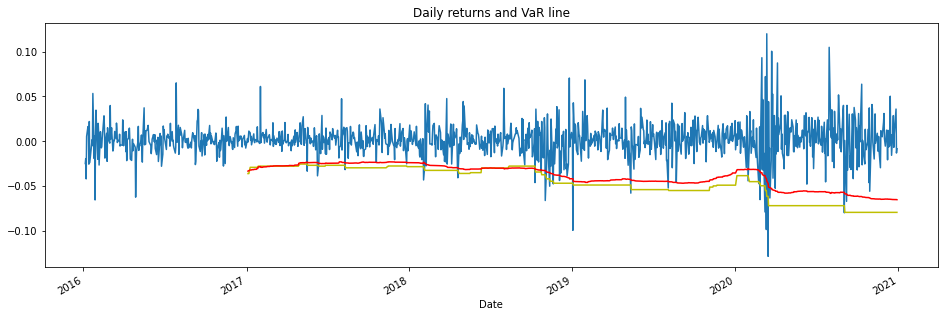

In [ ]:
plt.figure(figsize=(16,5))
returns.plot()
(-VaRs).plot(color='y')
(-VaRs_param).plot(color='r')

plt.title("Daily returns and VaR line");

In [ ]:
VaRs.head()

In [ ]:
#оцениваем пробития
hits = returns[VaRs.index] < -VaRs
hits
#false это когда нет пробития

Date
2017-01-04    False
2017-01-05    False
2017-01-06    False
2017-01-09    False
2017-01-10    False
              ...  
2020-12-23    False
2020-12-24    False
2020-12-28    False
2020-12-29    False
2020-12-30    False
Name: Adj Close, Length: 1005, dtype: bool

In [ ]:
hit_times = hits.index[hits]
hit_times

DatetimeIndex(['2017-05-17', '2017-06-09', '2017-08-10', '2018-02-02',
               '2018-04-20', '2018-10-10', '2018-11-02', '2018-11-12',
               '2018-11-20', '2019-01-03', '2019-05-13', '2020-01-31',
               '2020-02-24', '2020-02-27', '2020-03-09', '2020-03-12',
               '2020-03-16', '2020-09-03'],
              dtype='datetime64[ns]', name='Date', freq=None)

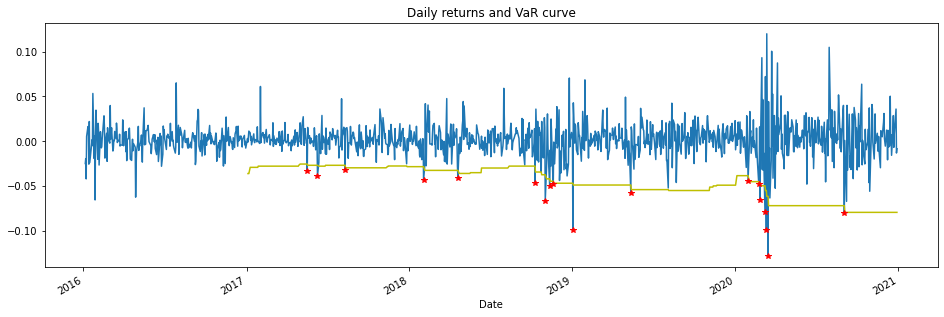

In [ ]:
plt.figure(figsize=(16,5))
returns.plot()
(-VaRs).plot(color='y')
plt.plot(hit_times, returns[hit_times], 'r*')

plt.title("Daily returns and VaR curve");

In [ ]:
N = hits.size
n = hits.sum()
N, n # N - количество наблюдений, n - количество пробоев VaR

(1005, 18)

In [ ]:
# Hit fraction (expected 0.01). Вероятность пробоя = 1% (1 - level)
n / N * 100
# по сути 1,79 больше 1 уровня значимости, но так сравнивать нельзя, надо делать
# бэктест, потому что вар 99 это теор модель, а мы считаем на эмпирических данных

1.791044776119403

#Бэкстестиг

Используем биномиальный тест на покрытие

H0:  𝑛∼𝐵(𝑁,𝑞),𝑞=1−𝑙𝑒𝑣𝑒𝑙

In [ ]:
# А действительно ли вероятность пробоя = 1%? двусторонний биномиальный тест
p_val = ss.binom_test(n, N, 1-level, alternative="two-sided")
p_val * 100
# идея тесте: сравниваем со средним ожидаемым количеством пробоев (вар), считаем количество пробоев вправо и влево от среднего

2.4177619417213485

In [ ]:
# А действительно ли вероятность пробоя <= 1%? односторонний биномиальный тест
p_val = ss.binom_test(n, N, 1-level, alternative="greater")
p_val * 100

1.4469466935299535

Как можно интерпретировать полученные результаты на основе p-value?

In [ ]:
# Правило сфетофора, trafic light room, если пивэлью будет больше 5 процентов,
# при уровне значимости 95 процентов, мы не можем отвергнуть гипотезу нулевую,
# модель признается качественной  - зеленый

# если пивэлью меньше 5 процентов но не сильно, пробоев больше чем критическое
# значение, но не сильно, модель можно применять, она ошибочно оенена как
# плохая, возможно вар слишком маленький, цвет желтый

#если пивэлью супермаленькое - в топку эту модель - цвет красный
def zone(p):
  if p > 0.05:
    return "green"
  elif p > 0.0001:
    return "yellow"
  else:
    return "red"

In [ ]:
zone(p_val)

'yellow'

### Какой тест использовать? Односторонным или двустороннонним?

Регулирование? = односторонный тест с пороговым значением "не хуже, чем 99.."

Внутренняя разработка или тест купленной системы? = односторонний тест

Если не независимые пробои - распределение может быть небиномиальным, с тяжелыми хвостами и тесты будут работать некорректно. Поэтому необходимо тестировать независимость.


Тест на независимость: $P(Hit_{t+1}\,|\,Hit_t) \overset{?}{=} P(Hit_{t+1}\,|\, \overline{Hit_t})$

In [ ]:
hits_yeasterday = hits.shift(1).dropna().astype(bool)
hits_today = hits[hits_yeasterday.index]
n_hits_today_given_no_hit_yeasterday = (hits_today & ~(hits_yeasterday)).sum()
n_hits_today_given_hit_yeasterday = (hits_today & hits_yeasterday).sum()
print(n_hits_today_given_no_hit_yeasterday, n_hits_today_given_hit_yeasterday)

18 0


Пробои следуют за спокойными днями, Не повезло! Нет последовательность из пробоев!

Альтернативный тест: исследование времени между пробитиями VaR - если нулевая гипотеза верна, распределение должны быть экспоненциальным (здесь нестрогий тест;  `Christoffersen, Pelltier (2004)` - строгий тест).

In [ ]:
hit_deltas = np.diff(np.hstack([VaRs.index[[0]].values, hit_times.values])) / np.timedelta64(1, 'D')

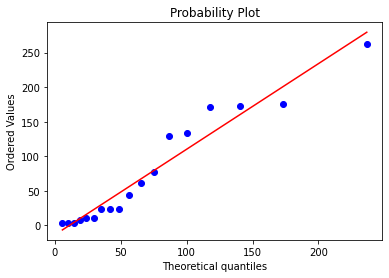

In [ ]:
params = ss.expon.fit(hit_deltas)
ss.probplot(hit_deltas, dist=ss.expon(*params), plot=plt);
# если все хорошо, мы должны увидеть синие точки на красной линии, если есть волны и отклонения, скорее всего наблюдения не независимые

Супер важный технический момент при реализации бэктеста.

Пропуски данных (P&L или VaR)

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
losses = [10, 11, 12, 11, 10, 9, 11, 13, 11, 9, 8, 9]
VaRs_3m_ahead = [9.5, 9, 8.5, 9, 9.5, 10.5, 9, 10, 11, 12, 11, 10]

df = pd.DataFrame({"Month": months, "Losses": losses, "VaR": VaRs_3m_ahead})
df = df.set_index("Month")
#print(df.to_string(index=False))
df

,Losses,VaR
Month,,
Jan,10,9.5
Feb,11,9.0
Mar,12,8.5
Apr,11,9.0
May,10,9.5
Jun,9,10.5
Jul,11,9.0
Aug,13,10.0
Sep,11,11.0


In [ ]:
pd.concat([df['Losses'], df['VaR'].shift(1)], axis=1)

,Losses,VaR
Month,,
Jan,10,NaN
Feb,11,9.5
Mar,12,9.0
Apr,11,8.5
May,10,9.0
Jun,9,9.5
Jul,11,10.5
Aug,13,9.0
Sep,11,10.0


In [ ]:
hits = df['Losses'] > df['VaR'].shift(1)
# this is bad... We don't have an observation for Jan!!!
hits

Month
Jan    False
Feb     True
Mar     True
Apr     True
May     True
Jun    False
Jul     True
Aug     True
Sep     True
Oct    False
Nov    False
Dec    False
dtype: bool

In [ ]:
n = hits.sum()
N = hits.size
N, n

(12, 7)

In [ ]:
df['VaR'] = df['VaR'].shift(1)
df.dropna(inplace=True)
hits = df['Losses'] > df['VaR']
n = hits.sum()
N = hits.size
N, n

(11, 7)